Продолжим исследовать цену на недвижимость в окрестностях Сиэттла. Подключим файл и все необходимые компоненты:

In [ ]:
data <- read.csv("kc_house_data.csv", header = TRUE, stringsAsFactors = FALSE)
if (!require("lmtest")) install.packages("lmtest")
if (!require("car")) install.packages("car")
if (!require("nortest")) install.packages("nortest")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tseries")) install.packages("tseries")
if (!require("dplyr")) install.packages("dplyr")
library(lmtest)
library(car)
library(tseries)
library(dplyr)
library(nortest)
library(ggplot2)

Создадим матрицу X и вектор y:



In [ ]:
lin_model <- model.matrix(~ sqft_living + sqft_lot + sqft_above, data = data)
X <- lin_model
y <- data$price

Оценим коэффициенты с помощью формулы:

$\hat \beta = (X^T X)^{-1}X^Ty$, \
где X - матрица независимых переменных с добавленным столбцом единиц для свободного коэффициента \
y - вектор зависимой переменной



In [ ]:
beta_hat <- solve(t(X) %*% X) %*% t(X) %*% y
cat("Оценки коэффициентов:", beta_hat)

Оценки коэффициентов: -41445.12 296.1516 -0.2781841 -16.90343

Коэффициент 296.1516, относящийся к sqrt_living означает, что увеличение жилой площади на 1 кв. фут связано с ростом цены на ~296 долларов, по крайней мере это ожидается. В дальнейшем проверим эту гипотезу.

Далее посчитаем остаточную дисперсию: \
$ \hat \sigma^2 = \frac{RSS}{n-k-1}$, \
где $ RSS = \sum_{i=1}^{n} (y_i - \hat y_i)^2$ - сумма квадратов остатков, \
n - количество наблюдений \
k - количество независимых переменных без учёта свободного коэффициента

In [ ]:
y_hat <- X %*% beta_hat
residuals <- y - y_hat
RSS <- sum(residuals^2)
n <- nrow(X)
k <- ncol(X) - 1
sigma_sq_hat <- RSS / (n - k - 1)
cat("Остаточная дисперсия:", sigma_sq_hat)

Остаточная дисперсия: 68179410014

Как мы видим, остаточная дисперсия очень великая. Это говорит о том, что модель объясняет малую часть вариации цен.

Построим доверительный интервал для коэффициентов:

In [ ]:
conf_int <- confint(model, level = 0.95)
cat("95% доверительные интервалы для коэффициентов:", conf_int)

95% доверительные интервалы для коэффициентов: -50157.31 288.2723 -0.3637132 -25.65966 -32732.94 304.031 -0.192655 -8.147197

Для остаточной дисперсии:

In [ ]:
n <- nobs(model)
k <- length(coef(model)) - 1
df <- n - k - 1

alpha <- 0.05
chi2_lower <- qchisq(1 - alpha/2, df)
chi2_upper <- qchisq(alpha/2, df)

ci_lower <- (df * sigma_sq_hat) / chi2_lower
ci_upper <- (df * sigma_sq_hat) / chi2_upper

cat(sprintf("95%% ДИ для остаточной дисперсии: (%.2e, %.2e)", ci_lower, ci_upper))

95% ДИ для остаточной дисперсии: (6.69e+10, 6.95e+10)

Коэффициент детерминации:

In [ ]:
y <- data$price
y_mean <- mean(y)
TSS <- sum((y - y_mean)^2)
residuals <- resid(model)
RSS <- sum(residuals^2)
R_squared_manual <- 1 - (RSS / TSS)
cat("Коэффициент детерминации R²:", R_squared_manual)

Коэффициент детерминации R²: 0.4942221

Все коэффициенты значимы следует из доверительного интервала для коэффициентов.
Из доверительного интервала для остаточной дисперсии модель имеет значительный разброс ошибок, что указывает на наличие неучтённых факторов, влияющих на цену.
Из коэффициента детерминации следует что  около половины изменчивости цен связано с включёнными в модель предикторами (sqft_living, sqft_lot, sqft_above). Для улучшения модели стоит добавить новые переменные (например, местоположение, число комнат).


Теперь проверим нормальность остатков:


Тест Харке-Бера:

	Jarque Bera Test

data:  resid(model)
X-squared = 535921, df = 2, p-value < 2.2e-16



[1] 7253 3915

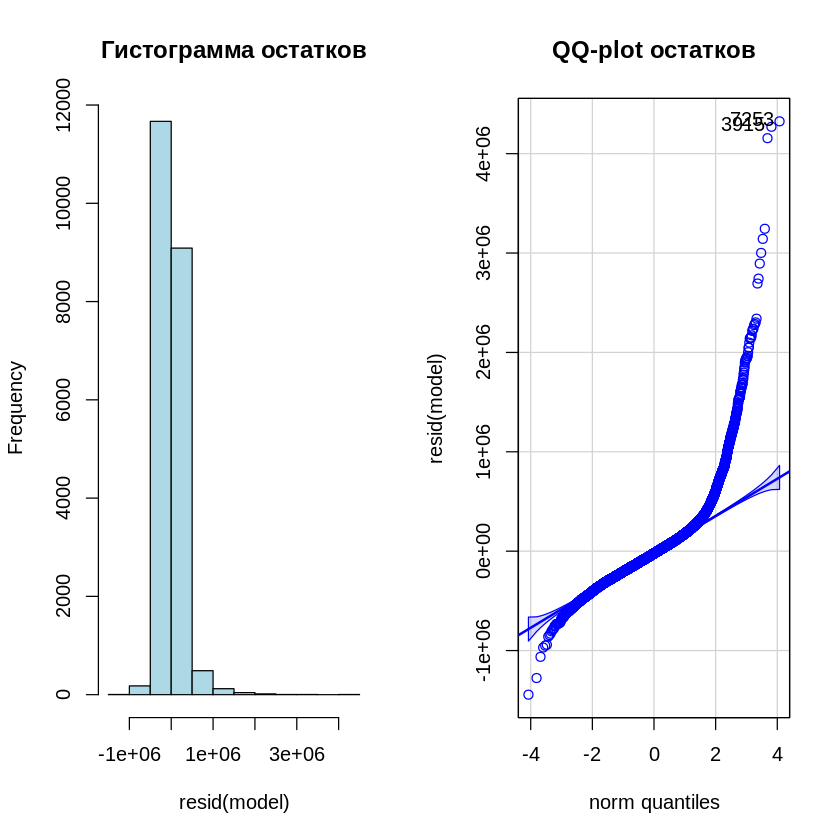

In [ ]:
jb_test <- jarque.bera.test(resid(model))
cat("\nТест Харке-Бера:\n")
print(jb_test)
par(mfrow = c(1,2))
hist(resid(model), main = "Гистограмма остатков", col = "lightblue")
qqPlot(resid(model), main = "QQ-plot остатков", col = "blue")

Отвергаем нормальность распределения остатков.

Перейдём к проверке гипотез:

1. Чем больше жилая площадь, тем больше цена \
Формализуем это. Жилая площадь - sqrt_living. Гипотезы $H_0$ и $H_1$ будут следующими: \
$H_0: \beta_{sqrt\_living} \le 0 \\
H_1: \beta_{sqrt\_living} > 0
$   

Коэффициент при sqft_living равен 296.15 > 0, что согласуется с $H_1$

Проверим теперь статистическую значимость через t-test:

In [ ]:
model <- lm(price ~ sqft_living + sqft_lot + sqft_above, data = data)
summary(model)


Call:
lm(formula = price ~ sqft_living + sqft_lot + sqft_above, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1443775  -147244   -22779   105537  4325358 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.145e+04  4.445e+03  -9.324  < 2e-16 ***
sqft_living  2.962e+02  4.020e+00  73.671  < 2e-16 ***
sqft_lot    -2.782e-01  4.364e-02  -6.375 1.86e-10 ***
sqft_above  -1.690e+01  4.467e+00  -3.784 0.000155 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 261100 on 21609 degrees of freedom
Multiple R-squared:  0.4942,	Adjusted R-squared:  0.4942 
F-statistic:  7038 on 3 and 21609 DF,  p-value: < 2.2e-16


p_value < 0.05, значит отвергаем $H_0$, а также коэффициент при sqrt_living равен 296.15 > 0 $ => $ Чем больше «жилая» площадь, тем больше цена

2. Цена зависит от "sqrt_lot" \
Опять же формализуем это: \
$H_0: \beta_{sqrt\_lot} = 0$ \
$H_1: \beta_{sqrt\_lot} \ne 0$

Из таблички в summary(model) мы видим что p_value = 1.86e-10, что означает что цена зависит от площади. Несмотря на то что обычно ожидается "больший участок должен повышать стоимость", мы имеем обратное "больший участок должен снижать стоимость" из-за отрицательного коэффициента sqrt_lot. \
В действительности же это правда, из-за нескольких факторов: \
1. Большие участки расположены в пригородах или сельских районах, где стоимость земли ниже из-за меньшей доступности инфраструктуры, рабочих мест и услуг.
2. В условиях дефицита жилья и высоких цен в Сиэтле покупатели могут отдавать предпочтение более компактным и доступным по цене объектам недвижимости. Большие участки могут требовать дополнительных затрат на обслуживание и не соответствовать потребностям большинства покупателей.
3. В Сиэтле действуют строгие правила зонирования, ограничивающие плотность застройки. В некоторых районах минимальный размер участка для строительства может быть большим, что ограничивает возможность разделения земли на более мелкие участки и строительства дополнительных единиц жилья. Это снижает потенциальную доходность больших участков, особенно если они не могут быть эффективно использованы для застройки.
4. Новые законы в штате Вашингтон направлены на увеличение плотности застройки, включая разрешение на строительство многоквартирных домов на ранее предназначенных для односемейных домов участках. Это повышает ценность меньших участков, подходящих для такой застройки, в то время как большие участки без возможности разделения могут терять в привлекательности. \
Источники:
 [Axios](https://www.axios.com/local/seattle/2025/05/21/washington-state-housing-construction-reform), [The Urbanist](www.theurbanist.org/2025/05/14/the-builders-remedy-is-coming-to-washington-state/), [Benchworks](https://beachworks.org/2024/07/29/3-ways-rezoning-boosts-affordable-housing-in-seattle/?utm_source=chatgpt.com)


*3.* Проверим гипотезу $H_0$ о равенстве одновременно нулю коэффициентов при "жилой" площади и "sqrt-above" против альтернативы $H_1 = \bar{H_0}$

Формализуем это: \
Гипотеза $H_0: B_{sqrt\_living} =B_{sqrt\_above} = 0 $ \
Гипотеза $H_1:$ хотя бы $1 \ne 0$ \
Для равенства моделей воспользуемся F-test: \
Создадим полную модель, затем ограниченную и проведём F-test:

In [ ]:
full_model <- lm(price ~ sqft_living + sqft_lot + sqft_above, data = data)
restricted_model <- lm(price ~ sqft_lot, data = data)
anova(restricted_model, full_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21611,2.889500e+15,NA,NA,NA,NA
2,21609,1.473289e+15,2,1.416211e+15,10385.91,0


Из этогго мы видим что p-value < 0.05 $ => $ гипотеза $H_0$ отвергается.Переменные sqft_living и/или sqft_above вносят значимый вклад в объяснение вариации цены.

Теперь рассмотрим ANOVA.  Приведены данные о мобильных телефонах. Фактор– ценовая категория, выходная переменная– емкость аккумулятора

In [ ]:
data <- read.csv("mobile_phones.csv", header = TRUE, stringsAsFactors = FALSE)

Преобразуем ценовую категоирю в фактор:

In [ ]:
data$price_range <- factor(data$price_range)

Далее рассмотрим распределение ёмкости аккумулятора по ценовым категориям:

price_range,mean_battery,sd_battery,n
<fct>,<dbl>,<dbl>,<int>
0,1116.902,410.8013,500
1,1228.868,438.6145,500
2,1228.320,452.8631,500
3,1379.984,414.9923,500


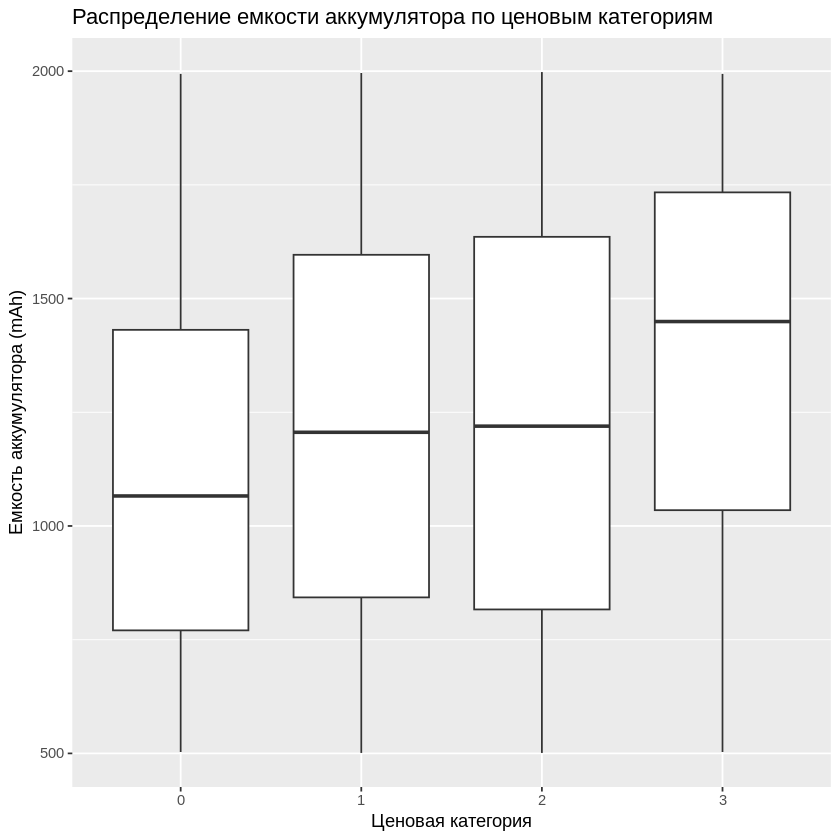

In [ ]:
data %>%
  group_by(price_range) %>%
  summarise(
    mean_battery = mean(battery_power),
    sd_battery = sd(battery_power),
    n = n()
  )

ggplot(data, aes(x = price_range, y = battery_power)) +
  geom_boxplot() +
  labs(title = "Распределение емкости аккумулятора по ценовым категориям",
       x = "Ценовая категория",
       y = "Емкость аккумулятора (mAh)")

Как мы видим наибольшая ёмкость аккумулятора наблюдается в наибольшей ценовой категории, что соответсвует интуиции \
Теперь построим ANOVA:

In [ ]:
model <- aov(battery_power ~ price_range, data = data)
summary(model)

              Df    Sum Sq Mean Sq F value Pr(>F)    
price_range    3  17500101 5833367    31.6 <2e-16 ***
Residuals   1996 368483530  184611                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Гипотеза о равенстве средних отвергается (p < 0.05). Емкость аккумулятора значимо отличается между ценовыми категориями.

Проверим также условия ANOVA:


	Shapiro-Wilk normality test

data:  resid(model)
W = 0.96688, p-value < 2.2e-16


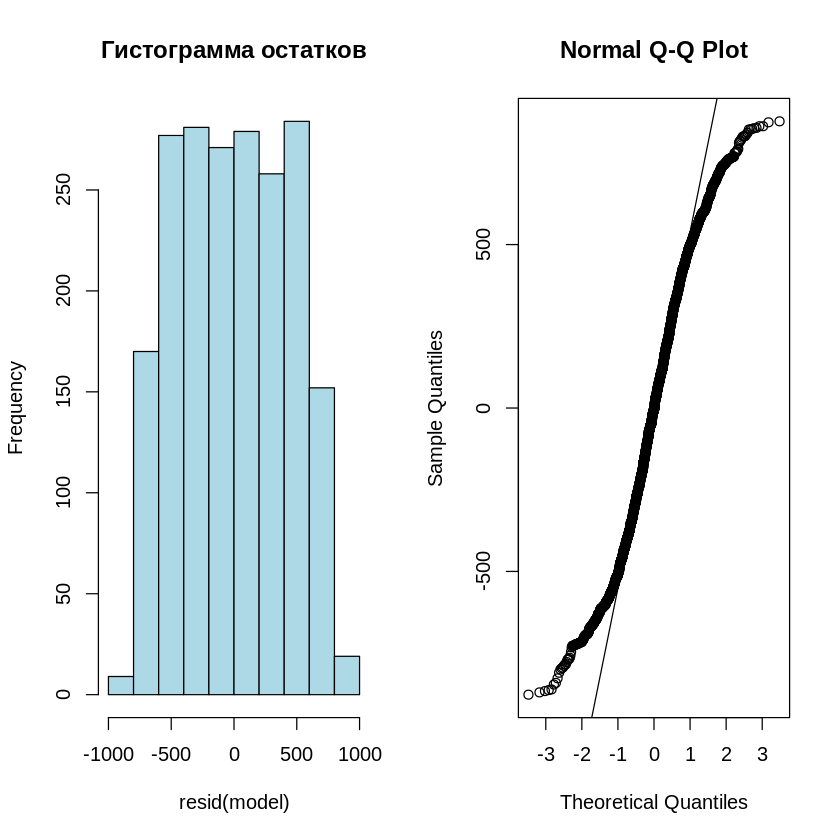

In [ ]:
shapiro.test(resid(model))
par(mfrow = c(1,2))
hist(resid(model), main = "Гистограмма остатков", col = "lightblue")
qqnorm(resid(model))
qqline(resid(model))

Несмотря на нарушение нормальности, ANOVA устойчив к умеренным отклонениям от нормальности, особенно при большом размере выборки (n > 30 в каждой группе), поэтому в нашем случае из-за огромности выборки это применимо \
Проверим гомогенность дисперсий:

In [ ]:
leveneTest(battery_power ~ price_range, data = data)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,5.608473,0.0007921156
,1996,NA,NA


Гипотеза о равенстве дисперсий отвергается (p < 0.05). Дисперсии ёмкости аккумулятора неоднородны между ценовыми категориями.

Ни гомогенность, ни нормальность не получается, из-за чего ANOVA становится трудно применимой, хоть и имеется большая выборка.
Тогда посмотрим на тест Крускалла-Уоллиса:

In [ ]:
kruskal.test(battery_power ~ price_range, data = data)


	Kruskal-Wallis rank sum test

data:  battery_power by price_range
Kruskal-Wallis chi-squared = 90.136, df = 3, p-value < 2.2e-16


Ёмкость аккумулятора значимо различается между ценовыми категориями, но на практике они имеют ограниченную значимость.